# Misc 3 - Bounty hunt

Let's try something different today - crack a small bounty!
The description says

![](bounty1.png)

Looking inside [lb_cifar10.py](https://github.com/tinygrad/tinygrad/blob/419a1286f2ec81c5c369dc41a7b4a9a1865d1e42/examples/hlb_cifar10.py), indeed, the 2 functions have to convert the tensor to numpy and back. I think we actually want to get rid of all numpy code inside the training loop.

Let's separate the 2 function in the notebook for convenience.

In [ ]:
import os
os.environ["CUDA"]="1"

In [ ]:
import tinygrad
import tinygrad.nn
from tinygrad import Tensor, dtypes
from tinygrad.helpers import getenv, Timing, Context
from tinygrad.device import Device

In [ ]:
# return a binary mask in the format of BS x C x H x W where H x W contains a random square mask
def make_square_mask(shape, mask_size) -> Tensor:
    BS, _, H, W = shape
    low_x = Tensor.randint(BS, low=0, high=W-mask_size).reshape(BS,1,1,1)
    low_y = Tensor.randint(BS, low=0, high=H-mask_size).reshape(BS,1,1,1)
    idx_x = Tensor.arange(W, dtype=dtypes.int32).reshape((1,1,1,W))
    idx_y = Tensor.arange(H, dtype=dtypes.int32).reshape((1,1,H,1))
    return (idx_x >= low_x) * (idx_x < (low_x + mask_size)) * (idx_y >= low_y) * (idx_y < (low_y + mask_size))


This one does not use numpy, but is used by both offenders, let's confirm what it does.

Aatually, let's use [🫀Lovely Grad](https://github.com/xl0/lovely-grad) to make things easier.

In [ ]:
from lovely_grad import monkey_patch
monkey_patch() # You either love it or hate it, the choice is yours. :P

Tensor[16, 1, 36, 36] dtypes.bool n=20736 x∈[False, True] μ=0.198 σ=0.398 CUDA Realized MUL


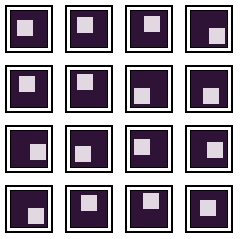

In [ ]:
mask = make_square_mask((16, 3, 36, 36), 16)
print(mask)
mask.chans

I think this is quite obvious - it masks random square patches inside the image. Note that the patches differ within batch.

I'm actually not sure if it makes a difference - transformations are often applied batch-wise, but I can see how it would be better to pick the patches at random within a batch, and this is a feature used by both `cutmix` and `random_crop`.

Let's start with `random_crop`.

In [ ]:
def random_crop(X:Tensor, crop_size=32):
    mask = make_square_mask(X.shape, crop_size)
    mask = mask.expand((-1,3,-1,-1))
    X_cropped = Tensor(X.numpy()[mask.numpy()])
    return X_cropped.reshape((-1, 3, crop_size, crop_size))

Ok, this is quite obvious too. I'm not sure about the last reshape - is it even needed?

Tensor[16, 3, 36, 36] dtypes.bool n=62208 x∈[False, True] μ=0.790 σ=0.407 CUDA Realized EXPAND


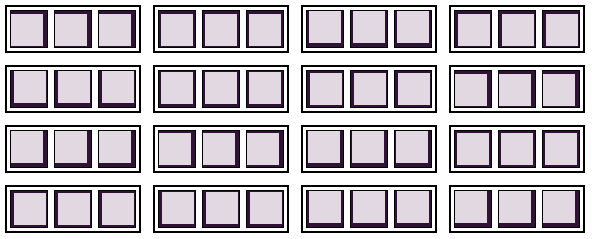

In [ ]:
crop_size=32
X = Tensor.randn(16, 3, 36, 36)
mask = make_square_mask(X.shape, crop_size).expand(-1, 3, -1, -1)
print(mask)
mask.chans

In [ ]:
# X[mask_expanded] - this does not work - boolean mask indexing is not supported in TinyGrad.

X_cropped = Tensor(X.numpy()[mask.numpy()])
X_cropped

Tensor[49152] x∈[-3.884, 4.028] μ=0.001 σ=1.005 CUDA Realized COPY

Ok, yeah, the bool indexing loses the shape.

Does not really matter, because TinyGtad does not support bool indexing, at least for now. And I don't think implementing it is within the scope for this bounty.

Let's look at the [Tensor docs](https://docs.tinygrad.org/tensor/movement/#tinygrad.Tensor.__getitem__) for our options.


Tensor[1, 1, 10, 10] n=100 x∈[0., 1.000] μ=0.500 σ=0.293 CUDA Realized RESHAPE


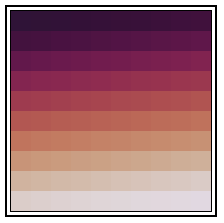

In [ ]:
T = Tensor.linspace(0, 1, 100).reshape(1, 1, 10, 10)
print(T)
T.chans(scale=20)

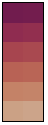

In [ ]:
T[:,:, Tensor([2,2,3,3,4,4,5,5,6,6,7,7]), Tensor([4,5,4,5,4,5,4,5,4,5,4,5])].reshape(1, 6, 2).chans(scale=20)


No this is not the way.

But [`.masked_select()`](https://docs.tinygrad.org/tensor/ops/#tinygrad.Tensor.masked_select) seems to be exactly what we want here!

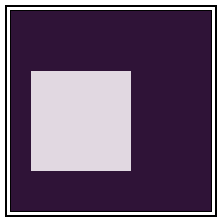

In [ ]:
mini_mask = make_square_mask(T.shape, 5)
mini_mask.chans(scale=20)

Tensor[1, 1, 5, 5] n=25 x∈[0.313, 0.758] μ=0.535 σ=0.147 CUDA Realized RESHAPE


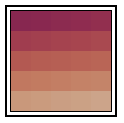

In [ ]:
res = T.masked_select(mini_mask).reshape(1,1,5,5)
print(res)

res.chans(scale=20)

Ok, this looks about right!

In [ ]:
def random_crop_tensor(X:Tensor, crop_size=32):
    mask = make_square_mask(X.shape, crop_size)
    mask = mask.expand((-1,3,-1,-1))
    return X.masked_select(mask).reshape((-1, 3, crop_size, crop_size))

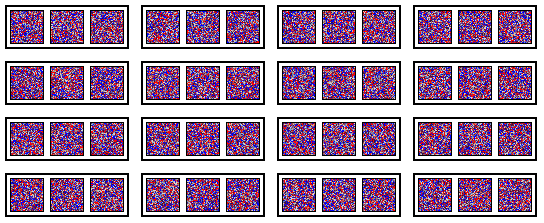

In [ ]:
random_crop_tensor(X).chans

In [ ]:
Tensor.manual_seed(69)
c1 = random_crop_tensor(X)

Tensor.manual_seed(69)
c2 = random_crop(X)

(c1 == c2).all().item()

True

Ok, this works. What about the speed?

In [ ]:
X = Tensor.randn(512, 3, 36, 36).realize()

for i in range(5):
    with Timing("random_crop "):
        random_crop(X).numpy()
        Device[X.device].synchronize()

    with Timing("random_crop_tensor "):
        random_crop_tensor(X).numpy()
        Device[X.device].synchronize()

random_crop 203.79 ms
random_crop_tensor 1077.24 ms
random_crop  31.47 ms
random_crop_tensor 804.61 ms
random_crop  30.40 ms
random_crop_tensor 799.93 ms
random_crop  29.42 ms
random_crop_tensor 804.96 ms
random_crop  30.08 ms
random_crop_tensor 801.05 ms


Ok, WTF? We are an order of magnitude slower?!

In [ ]:
X1 = Tensor.randn(512, 3, 36, 36).contiguous().realize()
X2 = Tensor.randn(512, 3, 36, 36).contiguous().realize()

mask1 = make_square_mask(X1.shape, crop_size).expand((-1,3,-1,-1))
mask2 = make_square_mask(X2.shape, crop_size).expand((-1,3,-1,-1))

for i in range(5):
    with Timing("masked_select "):
        X1.masked_select(mask1).realize()
        Device[X1.device].synchronize()

    with Timing("numpy masking "):
        Tensor(X2.numpy()[mask2.numpy()]).realize()
        Device[X2.device].synchronize()


masked_select 801.15 ms
numpy masking  19.05 ms
masked_select 782.98 ms
numpy masking   9.06 ms
masked_select 795.76 ms
numpy masking   8.93 ms
masked_select 789.33 ms
numpy masking   9.99 ms
masked_select 797.46 ms
numpy masking   9.24 ms


Looks real, and it's caused by the `masked_select` being shit.

In [ ]:
from tinygrad.helpers import Context

with Context(DEBUG=2):
    mask = make_square_mask((1024, 3, 36, 36), crop_size).contiguous().realize()

scheduled 18 kernels in 16.74 ms
*** CUDA     652 r_9_4_9_4                                 arg  1 mem  0.06 GB tm     17.47us/     0.02ms (     0.00 GFLOPS    0.0|0.0     GB/s) ['arange']
*** CUDA     653 r_512_16_32                               arg  1 mem  0.06 GB tm     12.29us/     0.03ms (    16.67 GFLOPS    0.2|48.0    GB/s) ['randint']
*** CUDA     654 E_n19                                     arg  1 mem  0.06 GB tm     12.26us/     0.04ms (     0.00 GFLOPS    0.0|0.0     GB/s) ['randint']
*** CUDA     655 E_n20                                     arg  2 mem  0.06 GB tm     10.24us/     0.05ms (     0.00 GFLOPS    0.0|0.0     GB/s) ['randint']
*** CUDA     656 E_n21                                     arg  2 mem  0.06 GB tm     12.00us/     0.06ms (     0.00 GFLOPS    0.0|0.0     GB/s) ['randint']
*** CUDA     657 E_4_32_4n3                                arg  4 mem  0.06 GB tm     12.29us/     0.08ms (     6.29 GFLOPS    0.3|0.5     GB/s) ['randint']
*** CUDA     658 E_n20    

Ok, first, I feel this is already more complicated than it needs to be. But this is a separate concern.

In [ ]:
X = Tensor.randn(1024, 3, 36, 36).contiguous().realize()
mask = (make_square_mask((1024, 3, 36, 36), crop_size)
        .expand((-1,3,-1,-1))
        .contiguous()
        .realize())

with Context(DEBUG=2):
    X.masked_select(mask).realize()
    Device[X.device].synchronize()

*** CUDA     695 r_1944_4_8_16_64_4_4                      arg  2 mem  0.09 GB tm    210.05us/     0.45ms (  4852.30 GFLOPS   94.8|2198.7  GB/s) ['masked_select']
*** CUDA     696 r_162_32_3888_3_4                         arg  2 mem  0.09 GB tm    642.05us/     1.09ms (   376.71 GFLOPS   24.9|753.5   GB/s) ['masked_select']
*** CUDA     697 E_n24                                     arg  3 mem  0.09 GB tm     12.29us/     1.10ms (     0.00 GFLOPS    0.0|0.0     GB/s) ['masked_select']
*** CPU      698 copy        4,     CPU <- CUDA            arg  2 mem  0.09 GB tm     42.50us/     1.14ms (     0.00 GFLOPS    0.0|0.0     GB/s) 
*** CUDA     699 E_41472_32_3n2                            arg  3 mem  0.10 GB tm     32.54us/     1.18ms (   122.34 GFLOPS  980.6|1468.0  GB/s) 
*** CUDA     700 r_32768_32_786432_3_4                     arg  1 mem  0.10 GB tm     26.62us/     1.20ms (     0.00 GFLOPS  472.6|472.6   GB/s) ['masked_select']
*** CUDA     701 r_41472_32_995328_3_4n1                

Yes, this is absolutely unreasonable. And of course this is a known issue: [https://github.com/tinygrad/tinygrad/issues/10340](https://github.com/tinygrad/tinygrad/issues/10340)

`FUSE_ARANGE` improves the situation a bit, but not nearly enough.

And this is awkward, but looks like someone else is working on this bounty too, and they made some progress. Well, too late to stop now.

How else can we select a square region from a BCHW tensor? Let's try to use pad with negative padding.

In [ ]:
X = Tensor.randn(1024, 3, 36, 36).contiguous().realize()

for i in range(5):
    with Context(DEBUG=2):
        xp = X.pad(((0, 0), (0, 0), (-1, -3), (-4, 0))).contiguous().realize()
        Device[X.device].synchronize()

xp

*** CUDA     713 E_3072_2_16_8_4                           arg  2 mem  0.08 GB tm     18.50us/  3185.24ms (     0.00 GFLOPS 1360.6|1360.6  GB/s) ['contiguous', 'pad']
*** CUDA     714 E_3072_2_16_8_4                           arg  2 mem  0.09 GB tm     17.41us/  3185.26ms (     0.00 GFLOPS 1445.6|1445.6  GB/s) ['contiguous', 'pad']
*** CUDA     715 E_3072_2_16_8_4                           arg  2 mem  0.09 GB tm     14.43us/  3185.27ms (     0.00 GFLOPS 1743.8|1743.8  GB/s) ['contiguous', 'pad']
*** CUDA     716 E_3072_2_16_8_4                           arg  2 mem  0.09 GB tm     13.31us/  3185.29ms (     0.00 GFLOPS 1890.5|1890.5  GB/s) ['contiguous', 'pad']
*** CUDA     717 E_3072_2_16_8_4                           arg  2 mem  0.09 GB tm     14.34us/  3185.30ms (     0.00 GFLOPS 1755.4|1755.4  GB/s) ['contiguous', 'pad']


Tensor[1024, 3, 32, 32] n=3145728 x∈[-5.078, 5.079] μ=0.000 σ=1.000 CUDA

Much better!

Now, it's not equivalent to the original implementation that crops the images independently.

But, due to limited number of possible 32x32 crops inside a 36x36 image (just 4 horizontal x 4 vertical), we can

- Shuffle the dataset tensor
- Split into 16 equal parts
- Aply a different crop to each part
- Combine the parts back
- Shuffle again.

Let's see how fast it can go.

Actially first, let's measure the original random_crop properly.

In [ ]:
X = (tinygrad.nn.datasets.cifar()[0] / 255.0).pad(( (0,0), (0, 0), (2, 2), (2, 2))).realize()
Device[X.device].synchronize() # I'm not sure if this is the correct wat to micro-benchmark stuff tbh


for i in range(5):
    with Timing("random_crop "):
        Xf = random_crop(X).contiguous().realize()
        Device[X.device].synchronize()

Xf

random_crop 1820.42 ms
random_crop 1198.52 ms
random_crop 1207.71 ms
random_crop 1194.52 ms
random_crop 1217.51 ms


Tensor[50000, 3, 32, 32] n=153600000 x∈[0., 1.000] μ=0.443 σ=0.268 CUDA

In [ ]:
X = (tinygrad.nn.datasets.cifar()[0] / 255.0).pad(( (0,0), (0, 0), (2, 2), (2, 2))).realize()
Device[X.device].synchronize()

for i in range(5):
    with Timing("split "):
        Xl = X.split(X.shape[0]//16) # XXX This results in B=3125, which is prob not great for performance.

        Xp = [ x.pad(((0,0),(0, 0), (-2, -2), (-2, -2))) for x in Xl ] # Same padding for all, just checking the perf here.
        Xf = Tensor.cat(*Xp).contiguous().realize()
        Device[X.device].synchronize()

Xf

split  46.48 ms
split   5.76 ms
split   5.64 ms
split   5.55 ms
split   5.52 ms


Tensor[50000, 3, 32, 32] n=153600000 x∈[0., 1.000] μ=0.473 σ=0.252 CUDA

Not bad! Let's see how long it takes to shuffle.

In [ ]:
X = Tensor.randn(50000, 3*36*36).contiguous().realize()

with Context(DEBUG=0):
    for i in range(5):
        with Timing("randperm "):
            perm = Tensor.randperm(X.shape[0]).contiguous().realize()
            Device[X.device].synchronize()

        with Timing("shuffle "):
            X[perm].contiguous().realize()
            Device[X.device].synchronize()

randperm 999.90 ms
shuffle 2332.43 ms
randperm 343.54 ms
shuffle 2347.69 ms
randperm 333.62 ms
shuffle 2354.02 ms
randperm 344.51 ms
shuffle 2366.09 ms
randperm 338.18 ms
shuffle 2391.26 ms


This is too slow! Luckily, I checked Discord, and turns out that in this case `FUSE_ARANGE=1` actually makes a huge difference! 

In [ ]:
X = Tensor.randn(50000, 3*36*36).contiguous().realize()

with Context(DEBUG=0, FUSE_ARANGE=1):
    for i in range(5):
        with Timing("randperm "):
            perm = Tensor.randperm(X.shape[0]).contiguous().realize()
            Device[X.device].synchronize()

        with Timing("shuffle "):
            X[perm].contiguous().realize()
            Device[X.device].synchronize()

randperm 445.02 ms
shuffle  96.35 ms
randperm 257.62 ms
shuffle   6.94 ms
randperm 325.91 ms
shuffle   6.44 ms
randperm 322.97 ms
shuffle   6.43 ms
randperm 322.43 ms
shuffle   6.71 ms


What a difference an undocumented env variable can make!

Now randperm (generating random indices) takes the majority of the time.

We need to shuffle twice (before the crop and after), but I think we can just re-use the same permute tensor, and we need to shuffle the dataset once in any case, so we already have the perms.

In [ ]:
def negative_pad_grid(n=4):
    # Generate all possible padding combinations that sum to biting n elements from h and w.
    pad_options = [(-i, i-n) for i in range(n+1)]

    # Create all possible combinations of padding for left/right and top/bottom
    return [(pad_options[x % len(pad_options)], pad_options[y % len(pad_options)])
            for x in range(n) for y in range(n)]

negative_pad_grid()

[((0, -4), (0, -4)),
 ((0, -4), (-1, -3)),
 ((0, -4), (-2, -2)),
 ((0, -4), (-3, -1)),
 ((-1, -3), (0, -4)),
 ((-1, -3), (-1, -3)),
 ((-1, -3), (-2, -2)),
 ((-1, -3), (-3, -1)),
 ((-2, -2), (0, -4)),
 ((-2, -2), (-1, -3)),
 ((-2, -2), (-2, -2)),
 ((-2, -2), (-3, -1)),
 ((-3, -1), (0, -4)),
 ((-3, -1), (-1, -3)),
 ((-3, -1), (-2, -2)),
 ((-3, -1), (-3, -1))]

Now I'll split the dataset into 16 parts and apply the padding variants before merging it back and shuffling.

In [ ]:
def nonrandom_crop_instrumented(X:Tensor, permutes: Tensor, crop_size:int=32) -> Tensor:
    with Timing("split "):
        Xl = X.split(X.shape[0]//16) # XXX This results in B=3125, which is prob not great for performance, not sure if matters.
        for x in Xl: x.contiguous().realize()
        Device[X.device].synchronize()

    with Timing("pad "):
        Xp = [ x.pad(((0,0),(0, 0), *npad)).contiguous().realize() for x, npad in zip(Xl, negative_pad_grid()) ]
        Device[X.device].synchronize()

    with Timing("cat "):
        Xc = Tensor.cat(*Xp).contiguous().realize()
        Device[X.device].synchronize()

    with Timing("index "):
        Xm = Xc[permutes].contiguous().realize()
        Device[X.device].synchronize()

    return Xm

X = (tinygrad.nn.datasets.cifar()[0] / 255.0).pad(((0, 0), (0, 0), (2, 2), (2, 2))).contiguous().realize()
permutes = Tensor.randperm(X.shape[0]).contiguous().realize()

X = X[permutes].realize()
Device[X.device].synchronize()

for i in range(5):
    with Timing("nonrandom crop "), Context(FUSE_ARANGE=1):
        Xc = nonrandom_crop_instrumented(X, permutes).contiguous().realize()
        Device[X.device].synchronize()

split  50.00 ms
pad  68.46 ms
cat 326.88 ms
index  56.14 ms
nonrandom crop 502.24 ms
split  11.56 ms
pad  11.41 ms
cat   4.89 ms
index   5.93 ms
nonrandom crop  34.45 ms
split  11.97 ms
pad  11.84 ms
cat   5.02 ms
index   6.00 ms
nonrandom crop  35.44 ms
split  11.13 ms
pad  11.56 ms
cat   5.05 ms
index   6.06 ms
nonrandom crop  34.42 ms
split  11.70 ms
pad  12.68 ms
cat   5.14 ms
index   6.05 ms
nonrandom crop  36.17 ms


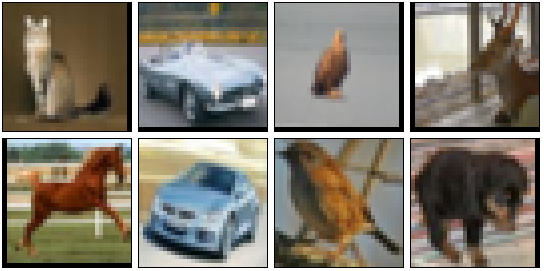

In [ ]:
Xc[:8].rgb(scale=4)

This seems to work fine -- we can see the black border that was added when the dataset was padded to 36x36.
Fast version:

In [ ]:
def nonrandom_crop(X:Tensor, permutes: Tensor, crop_size:int=32) -> Tensor:
    Xl = X.split(X.shape[0]//16) # XXX This results in B=3125, which is prob not great for performance, not sure if matters.
    Xp = [ x.pad(((0,0),(0, 0), *npad))for x, npad in zip(Xl, negative_pad_grid()) ]
    return Tensor.cat(*Xp)[permutes]

X = (tinygrad.nn.datasets.cifar()[0] / 255.0).pad((0, 0, 2, 2, 2, 2)).contiguous().realize()
permutes = Tensor.randperm(X.shape[0]).contiguous().realize()

X = X[permutes].realize()
Device[X.device].synchronize()

for i in range(10):
    with Timing("faster crop "), Context(FUSE_ARANGE=1):
        _ = nonrandom_crop(X, permutes).contiguous().realize()
        Device[X.device].synchronize()

faster crop 181.39 ms
faster crop  15.11 ms
faster crop  14.00 ms
faster crop  13.93 ms
faster crop  14.60 ms
faster crop  13.61 ms
faster crop  13.88 ms
faster crop  13.93 ms
faster crop  13.47 ms
faster crop  14.05 ms


This looks much better. Now let's try to do the same with cutmix.

In [ ]:
import random

def cutmix(X:Tensor, Y:Tensor, mask_size=3):
    # fill the square with randomly selected images from the same batch
    mask = make_square_mask(X.shape, mask_size)
    order = list(range(0, X.shape[0]))
    random.shuffle(order)
    X_patch = Tensor(X.numpy()[order], device=X.device, dtype=X.dtype)
    Y_patch = Tensor(Y.numpy()[order], device=Y.device, dtype=Y.dtype)
    X_cutmix = mask.where(X_patch, X)
    mix_portion = float(mask_size**2)/(X.shape[-2]*X.shape[-1])
    Y_cutmix = mix_portion * Y_patch + (1. - mix_portion) * Y
    return X_cutmix, Y_cutmix

I know what's happening here - we insert pieces from other images into each image, and adjust Y^ to match the amount of foreign pixels.

Not sure this should work with such small images/patches, but that's a question for anoher time.

Let's confirm that it behaves the way I think it does.

X=Tensor[8, 3, 32, 32] n=24576 x∈[0., 1.000] μ=0.537 σ=0.373 CUDA Realized ADD
Y=Tensor[8, 8] i32 n=64 x∈[0, 1] μ=0.125 σ=0.331 CUDA Realized WHERE
[[1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1]]


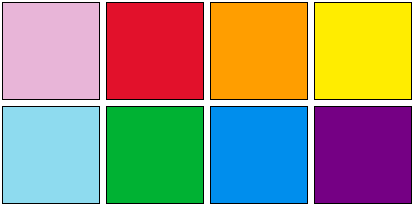

In [ ]:
colors = [
    [0.91, 0.71, 0.85],
    [0.89, 0.07, 0.17],
    [1.00, 0.62, 0.00],
    [1.00, 0.93, 0.00],
    [0.56, 0.86, 0.94],
    [0.00, 0.70, 0.20],
    [0.00, 0.56, 0.93],
    [0.46, 0.00, 0.52]
]

hw = 32
X = Tensor.stack(
    *[Tensor.stack(
        Tensor.full((hw, hw), colors[i][0]),
        Tensor.full((hw, hw), colors[i][1]),
        Tensor.full((hw, hw), colors[i][2])
    ) for i in range(len(colors))]
)

import tinygrad.nn

Y = Tensor([0,1,2,3,4,5,6,7]).one_hot()
print(f"{X=}")
print(f"{Y=}")
print(Y.numpy())
X.rgb(scale=3)


X=Tensor[8, 3, 32, 32] n=24576 x∈[0., 1.000] μ=0.537 σ=0.373 CUDA
Y=Tensor[8, 8] i32 n=64 x∈[0, 1] μ=0.125 σ=0.331 CUDA
[[0.991 0.    0.    0.009 0.    0.    0.    0.   ]
 [0.    0.991 0.009 0.    0.    0.    0.    0.   ]
 [0.    0.    0.991 0.    0.    0.009 0.    0.   ]
 [0.    0.    0.    0.991 0.    0.    0.009 0.   ]
 [0.    0.    0.    0.    0.991 0.    0.    0.009]
 [0.    0.    0.    0.    0.009 0.991 0.    0.   ]
 [0.009 0.    0.    0.    0.    0.    0.991 0.   ]
 [0.    0.009 0.    0.    0.    0.    0.    0.991]]


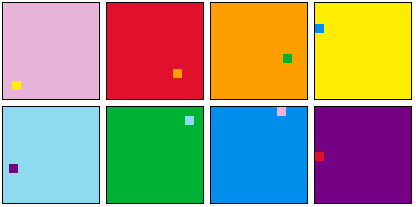

In [ ]:
Xc, Yc = cutmix(X, Y)
print(f"{X=}")
print(f"{Y=}")
print(Yc.numpy().round(3))
Xc.rgb(scale=3)

Yep, that's right. Now, how do we deal with the `order`?

In [ ]:
p = Tensor.randperm(20, device=X.device)
print(p)
print(p.numpy())

Tensor[20] i32 x∈[0, 19] μ=9.500 σ=5.766 CUDA Realized RESHAPE
[ 6 19  1  9 14 16 18 11 15  2 10 17 13  3  0  4  7  5 12  8]


Looks like we have the function just for this.

X_cutmix=Tensor[1, 8, 3, 32, 32] n=24576 x∈[0., 1.000] μ=0.537 σ=0.373 CUDA Realized WHERE
Y_cutmix=Tensor[1, 8, 8] n=64 x∈[0., 0.991] μ=0.125 σ=0.330 CUDA Realized ADD
[[[0.991 0.    0.    0.    0.009 0.    0.    0.   ]
  [0.    0.991 0.009 0.    0.    0.    0.    0.   ]
  [0.    0.    0.991 0.    0.    0.    0.    0.009]
  [0.    0.    0.    0.991 0.    0.009 0.    0.   ]
  [0.    0.    0.    0.    0.991 0.    0.009 0.   ]
  [0.009 0.    0.    0.    0.    0.991 0.    0.   ]
  [0.    0.009 0.    0.    0.    0.    0.991 0.   ]
  [0.    0.    0.    0.009 0.    0.    0.    0.991]]]


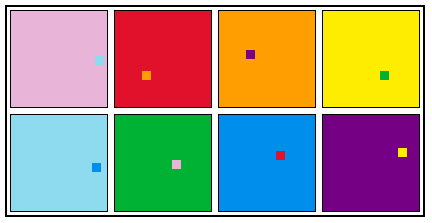

In [ ]:
# fill the square with randomly selected images from the same batch
mask_size = 3
mask = make_square_mask(X.shape, mask_size)


order = Tensor.randperm(X.shape[0], device=X.device)
X_patch = X[order].unsqueeze(0)
Y_patch = Y[order].unsqueeze(0)
X_cutmix = mask.where(X_patch, X)
mix_portion = float(mask_size**2)/(X.shape[-2]*X.shape[-1])
Y_cutmix = mix_portion * Y_patch + (1. - mix_portion) * Y

print(f"{X_cutmix=}")
print(f"{Y_cutmix=}")
print(Y_cutmix.numpy().round(3))
X_cutmix.rgb(scale=3)

Looks good.

In [ ]:
def cutmix_tensor(X, Y, mask_size=3):
  mask = make_square_mask(X.shape, mask_size)
  order = Tensor.randperm(X.shape[0], device=X.device)
  X_patch, Y_patch = X[order], Y[order]
  X_cutmix = mask.where(X_patch, X)
  mix_portion = float(mask_size**2)/(X.shape[-2]*X.shape[-1])
  Y_cutmix = mix_portion * Y_patch + (1. - mix_portion) * Y
  return X_cutmix, Y_cutmix

I can't reproduce the random order between implementations, but let's compare them side by side and with real images.

New one:

Xct=Tensor[16, 3, 32, 32] n=49152 x∈[0., 1.000] μ=0.434 σ=0.254 CUDA Realized WHERE
Yct=Tensor[16, 10] n=160 x∈[0., 0.952] μ=0.100 σ=0.285 CUDA Realized ADD
[[0.    0.    0.    0.    0.    0.    0.952 0.    0.    0.048]
 [0.    0.    0.    0.    0.    0.    0.048 0.    0.    0.952]
 [0.    0.    0.048 0.    0.    0.    0.    0.    0.    0.952]
 [0.    0.    0.    0.    0.952 0.    0.    0.048 0.    0.   ]
 [0.    0.952 0.    0.    0.048 0.    0.    0.    0.    0.   ]
 [0.    0.952 0.    0.    0.    0.    0.    0.    0.    0.048]
 [0.    0.048 0.952 0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.952 0.048 0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.048 0.952 0.   ]
 [0.    0.    0.    0.952 0.    0.    0.    0.    0.    0.048]
 [0.    0.048 0.    0.    0.952 0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.952 0.    0.048]
 [0.    0.    0.048 0.    0.    0.    0.    0.952 0.    0.   ]
 [0.    0.    0.952 0.  

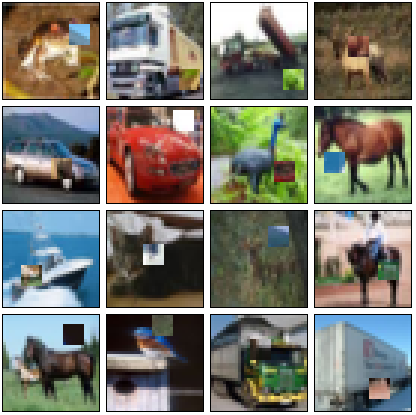

In [ ]:

X, Y, _, _ = tinygrad.nn.datasets.cifar()

X = X[:16] / 255.0
Y = Y[:16].one_hot()

Xct, Yct = cutmix_tensor(X, Y, 7)
print(f"{Xct=}")
print(f"{Yct=}")
print(Yct.numpy().round(3))
Xct.rgb(scale=3)

And the original

Xc=Tensor[16, 3, 32, 32] n=49152 x∈[0., 1.000] μ=0.430 σ=0.253 CUDA Realized WHERE
Yc=Tensor[16, 10] n=160 x∈[0., 1.000] μ=0.100 σ=0.288 CUDA Realized ADD
[[0.    0.    0.    0.    0.048 0.    0.952 0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.048 0.    0.952]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.952 0.    0.    0.048 0.    0.   ]
 [0.    0.952 0.    0.    0.    0.    0.    0.    0.    0.048]
 [0.    0.952 0.    0.    0.    0.    0.    0.    0.    0.048]
 [0.    0.048 0.952 0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.048 0.    0.    0.    0.952 0.    0.   ]
 [0.    0.    0.048 0.    0.    0.    0.    0.    0.952 0.   ]
 [0.    0.    0.    0.952 0.    0.    0.    0.    0.    0.048]
 [0.    0.    0.    0.    1.    0.    0.    0.    0.    0.   ]
 [0.    0.048 0.    0.    0.    0.    0.    0.952 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.952 0.    

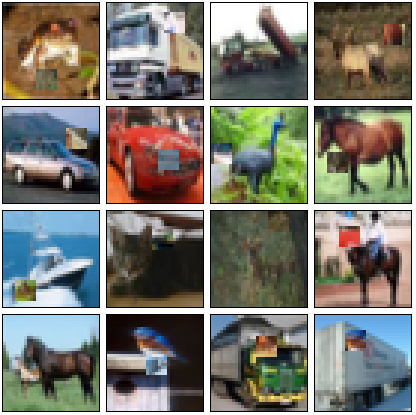

In [ ]:
Xc, Yc = cutmix(X, Y, 7)
print(f"{Xc=}")
print(f"{Yc=}")
print(Yc.numpy().round(3))
Xc.rgb(scale=3)

This looks sane, and the code is pretty simple, so let's check the performance.

In [ ]:
X, Y = tinygrad.nn.datasets.cifar()[:2]

X = (X / 255.0).pad(((0, 0), (0, 0), (2, 2), (2, 2))).contiguous().realize()
Y = Y.one_hot(10).contiguous().realize()

with Context(FUSE_ARANGE=1):
    for i in range(5):
        with Timing("cutmix "):
            Xcm, Ycm =  cutmix(X, Y, 3)
            Xcm.contiguous().contiguous().realize()
            Ycm.contiguous().contiguous().realize()
            Device[X.device].synchronize()

        with Timing("cutmix_tensor "):
            Xcm, Ycm = cutmix_tensor(X, Y, 3)
            Xcm.contiguous().contiguous().realize()
            Ycm.contiguous().contiguous().realize()
            Device[X.device].synchronize()


cutmix 1478.12 ms
cutmix_tensor 420.28 ms
cutmix 1253.05 ms
cutmix_tensor 431.40 ms
cutmix 1260.34 ms
cutmix_tensor 426.08 ms
cutmix 1230.40 ms
cutmix_tensor 300.24 ms
cutmix 1231.61 ms
cutmix_tensor 445.36 ms


Awesome!

Let me modify the code, and we can test/benchmark it.

I have to use FUSE_ARANGE in my case, so let's use it here too for fairness.

First, the original.

In [ ]:
%env TG_DIR=/home/xl0/projects/tinygrad
%env CUDA=1
%env FUSE_ARANGE=1
%env PYTHONPATH=/home/xl0/projects/tinygrad

!time -p python $TG_DIR/examples/hlb_cifar10_orig.py 2>&1 > cifar_numpy_1.log
!time -p python $TG_DIR/examples/hlb_cifar10_orig.py 2>&1 > cifar_numpy_2.log
!time -p python $TG_DIR/examples/hlb_cifar10_orig.py 2>&1 > cifar_numpy_3.log

env: TG_DIR=/home/xl0/projects/tinygrad
env: CUDA=1
env: FUSE_ARANGE=1
env: PYTHONPATH=/home/xl0/projects/tinygrad


real 109.64
user 101.22
sys 16.97
real 110.51
user 102.22
sys 16.84
real 110.13
user 101.70
sys 16.98


In [ ]:
!for f in cifar_numpy_?.log; do grep "eval" $f; done
!grep "shuffl" cifar_numpy_3.log

eval     9582/10240 93.57%,    0.40 val_loss STEP=1000 (in 1383.59 ms)
eval     9582/10240 93.57%,    0.40 val_loss STEP=1000 (in 1388.41 ms)
eval     9582/10240 93.57%,    0.40 val_loss STEP=1000 (in 1379.93 ms)


shuffling training dataset in 2665.80 ms (epoch=0)
shuffling training dataset in 1911.16 ms (epoch=1)
shuffling training dataset in 1854.85 ms (epoch=2)
shuffling training dataset in 1852.05 ms (epoch=3)
shuffling training dataset in 1852.64 ms (epoch=4)
shuffling training dataset in 1859.95 ms (epoch=5)
shuffling training dataset in 2862.86 ms (epoch=6)
shuffling training dataset in 2784.49 ms (epoch=7)
shuffling training dataset in 2790.19 ms (epoch=8)
shuffling training dataset in 2781.74 ms (epoch=9)
shuffling training dataset in 2779.49 ms (epoch=10)
shuffling test dataset in 163.23 ms (epoch=0)


And the new version.

In [ ]:
!time -p python $TG_DIR/examples/hlb_cifar10.py 2>&1 > cifar_nonumpy_1.log
!time -p python $TG_DIR/examples/hlb_cifar10.py 2>&1 > cifar_nonumpy_2.log
!time -p python $TG_DIR/examples/hlb_cifar10.py 2>&1 > cifar_nonumpy_3.log

real 101.98
user 108.97
sys 1.56
real 101.89
user 108.82
sys 1.63
real 102.12
user 109.10
sys 1.57


In [ ]:
!for f in cifar_nonumpy_?.log; do grep "eval" $f; done
!grep "shuffl" cifar_nonumpy_3.log

eval     9596/10240 93.71%,    0.41 val_loss STEP=1000 (in 1438.19 ms)
eval     9596/10240 93.71%,    0.41 val_loss STEP=1000 (in 1434.46 ms)
eval     9596/10240 93.71%,    0.41 val_loss STEP=1000 (in 1422.33 ms)


shuffling training dataset in 81.14 ms (epoch=0)
shuffling training dataset in 77.87 ms (epoch=1)
shuffling training dataset in 77.68 ms (epoch=2)
shuffling training dataset in 76.15 ms (epoch=3)
shuffling training dataset in 77.15 ms (epoch=4)
shuffling training dataset in 76.54 ms (epoch=5)
shuffling training dataset in 291.73 ms (epoch=6)
shuffling training dataset in 151.85 ms (epoch=7)
shuffling training dataset in 150.42 ms (epoch=8)
shuffling training dataset in 150.07 ms (epoch=9)
shuffling training dataset in 151.24 ms (epoch=10)
shuffling test dataset in 0.00 ms (epoch=0)


We are ~8 seconds (7%) faster now, and everything seems to work fine. I think it's time to send a PR.

In [ ]:
!cd $TG_DIR && git diff examples/hlb_cifar10.py

diff --git a/examples/hlb_cifar10.py b/examples/hlb_cifar10.py
index ff6c48b60..eeeca86b2 100644
--- a/examples/hlb_cifar10.py
+++ b/examples/hlb_cifar10.py
@@ -201,19 +201,25 @@ def train_cifar():
     idx_y = Tensor.arange(H, dtype=dtypes.int32).reshape((1,1,H,1))
     return (idx_x >= low_x) * (idx_x < (low_x + mask_size)) * (idx_y >= low_y) * (idx_y < (low_y + mask_size))
 
-  def random_crop(X:Tensor, crop_size=32):
-    mask = make_square_mask(X.shape, crop_size)
-    mask = mask.expand((-1,3,-1,-1))
-    X_cropped = Tensor(X.numpy()[mask.numpy()])
-    return X_cropped.reshape((-1, 3, crop_size, crop_size))
-
-  def cutmix(X:Tensor, Y:Tensor, mask_size=3):
-    # fill the square with randomly selected images from the same batch
+
+  def negative_pad_grid(n=4):
+      # Generate all possible padding combinations that sum to biting n elements from h and w.
+      pad_options = [(-i, i-n) for i in range(n+1)]
+
+      # Create all possible combinations of padding for left/right and

I see bunch of other things that could be improved in the code, but let's submit the PR and get some feedback...

You can read the rest of the story in this PR: [[bounty] Don't use numpy inside hlb_cifar10 training loop #10777](https://github.com/tinygrad/tinygrad/pull/10777)

Ok, so the story here is, [@IntendedConsequence](https://github.com/IntendedConsequence) also made good progress, but at the same time both our solutions were incomplete, [@geohot](https://github.com/geohot) bumped up the bounty amount, and suggested we work together.

And it was a good ideas - working with [@IntendedConsequence](https://github.com/IntendedConsequence) was a pleasure, and I think we ended up with the best solution.

Overall, would I recommend doung bounties for the payout? - Definitely not, we made less than $10/hour on this, and it was objectively not a hard issue.

But if you want to play with TinyGrad anyway, it's a good motivator, so in this sense, yes, jump right on it!